For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB

/Users/xiaojuan/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's [Oscar winner](http://www.rottentomatoes.com/m/birdman_2014/) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh or Rotten.

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As before, we'll start out with some exploratory data analysis.

---

##Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [2]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]

###1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [3]:
# enter your code below

print "Number of reviews: %i" % len(reviews)
print "The unique number of reviews(quotes): %i"%len(reviews.groupby('quote'))
print "The unique number of reviewers (critics): %i" %len(reviews.groupby('critic'))
print "The unique number of movies in review dataset: %i"%len(reviews.groupby('title'))
print "The unique number of movies in movie dataset: %i"%len(movies.groupby('title'))
print "The unique number of publication in reviews dataset: %i"%len(reviews.groupby('publication'))

Number of reviews: 13419
The unique number of reviews(quotes): 12814
The unique number of reviewers (critics): 540
The unique number of movies in review dataset: 1720
The unique number of movies in movie dataset: 9405
The unique number of publication in reviews dataset: 64


###1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

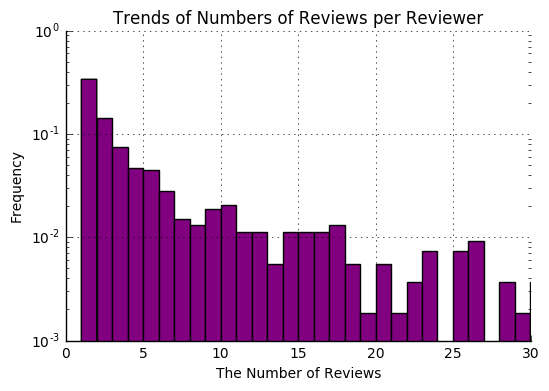

In [4]:
# prepare IPython to work with matplotlib and import the library to something convenient
%matplotlib inline  
import matplotlib.pyplot as plt  

# Get the number of reviews per reviewer
rePerReviewer = reviews.groupby('critic').size()

#Remove the right and top axis
ax = plt.subplot(111)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.tick_params(top = "off", right = "off")
#Change the color of the bars to be green and change the bin width to be $1000
plt.hist(rePerReviewer,bins = rePerReviewer.max(), normed=True,facecolor = 'purple', log = True)
#Add x and y labels
plt.ylabel("Frequency")
plt.xlabel("The Number of Reviews")
plt.title('Trends of Numbers of Reviews per Reviewer') 
plt.xlim([0,30])
plt.yscale('log', nonposy='clip')
plt.grid()  
plt.show()

###1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [5]:
#Create a new dataframe that only includes two columns
new_reviews = reviews.ix[:,('critic','fresh')]

#Count the reviews per reviewer
num_reviews = new_reviews.groupby('critic').count()

#Get the max and min review date based on the reviewer
max_date = reviews.groupby('critic').max().review_date
min_date = reviews.groupby('critic').min().review_date

#Add the min and max date to the new dataframe
num_reviews['first_review'] = min_date
num_reviews['last_review'] = max_date

#Sort the dataframe and get the top30 reviewer
num_reviews = num_reviews.reset_index().sort('fresh',ascending = False).head(30)

#Get the publication they work for
publication =[]
for critic in num_reviews.critic:
    for name, group in reviews.groupby('critic'):
        if name == critic:
            publication.append(np.unique(group['publication']))
            
num_reviews['publication'] = publication

#Recognize the dataframe
num_reviews = num_reviews.ix[:,('critic','publication','first_review','last_review')]

#Change the index
num_reviews.index = [i for i in range(1,31)]

#Show the result
num_reviews

/Users/xiaojuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,critic,publication,first_review,last_review
1,Roger Ebert,"[At the Movies, Chicago Sun-Times]",2000-01-01 00:00:00,2013-06-11 00:00:00
2,James Berardinelli,[ReelViews],1800-01-01 00:00:00,2012-02-07 00:00:00
3,Janet Maslin,[New York Times],2000-01-01 00:00:00,2010-09-07 00:00:00
4,Variety Staff,[Variety],2001-02-13 00:00:00,2012-08-15 00:00:00
5,Jonathan Rosenbaum,[Chicago Reader],1988-07-11 00:00:00,2013-10-22 00:00:00
6,Desson Thomson,[Washington Post],2000-01-01 00:00:00,2012-10-08 00:00:00
7,Geoff Andrew,[Time Out],2005-08-11 00:00:00,2012-04-05 00:00:00
8,Dave Kehr,"[Chicago Reader, Chicago Tribune, New York Dai...",2000-01-01 00:00:00,2013-11-20 00:00:00
9,Kenneth Turan,[Los Angeles Times],2000-01-01 00:00:00,2013-10-05 00:00:00
10,Mick LaSalle,[San Francisco Chronicle],2000-01-01 00:00:00,2009-11-25 00:00:00


###1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in red showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

/Users/xiaojuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


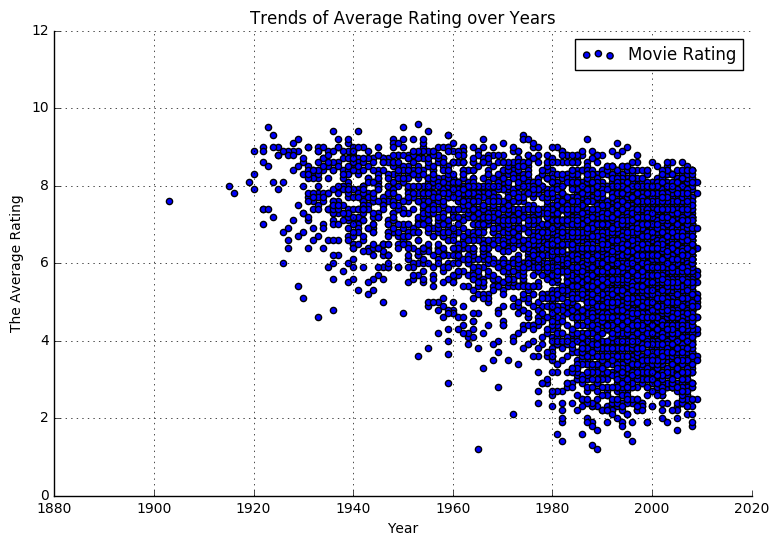

In [6]:
#Create a new dataframe that only includes columns needed
new_movie = movies.ix[:,('title','year','rtAllCriticsRating')]

#Change the data type of 'rtAllCriticRating' from object to numeric
rating = new_movie['rtAllCriticsRating'].convert_objects(convert_numeric=True)
new_movie['rating'] = rating

#Get the average rating
new_movie = new_movie.groupby(['title','year']).mean().dropna().reset_index()
new_movie = new_movie[new_movie['rating'] != 0]



#Create tow new variables: the average rating and year
year = new_movie.year
avg_rating = new_movie.rating
rate = new_movie.groupby('year').mean().rating


#Set the figure size
plt.figure(figsize=(9,6))

#Make a graph to show the relationship between the year and the average ratings
#Remove the right and top axis
ax = plt.subplot(111)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.tick_params(top = "off", right = "off")
#Change the color of the bars to be green and change the bin width to be $1000
ax.scatter(x = year, y = avg_rating, label = 'Movie Rating')
#Add x and y labels
plt.ylabel("The Average Rating")
plt.xlabel("Year")
plt.title('Trends of Average Rating over Years')  
plt.grid() 
plt.legend()
plt.show()

*enter your observations here*

The range of average rating becomes broader after 1960. Before 1960, almost all the average rating is above 5 or so. That means peopel are more satisfied about the movie. Or people wrote the review only when they felt good. After 1960, the range of average rating become much braoder. The bottom line can be 1 or so. And also the topline of the average rating also come down. Before the 1960, the average rating can be as high as 9.5 or so. The highest average rating comes down after 1960. That means people feel less satisfied about the movie. That also because more and more people can access internet, the rating become diverse.  

---

##Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the lecture notes (week 12) before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print "Original text is\n", '\n'.join(text)

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print
print "Transformed text vector is \n", x

# `get_feature_names` tracks which word is associated with each column of the transformed x
print
print "Words for each feature:"
print vectorizer.get_feature_names()

Original text is
machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
[[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
[u'learning', u'machine', u'rocks', u'rules']


###2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [8]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(reviews, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df = 0)
        
    #Recode the data, convert the fresh to 1 and rotten to 0
    reviews.ix[reviews['fresh'] == 'fresh', 'fresh'] = 1
    reviews.ix[reviews['fresh'] == 'rotten', 'fresh'] = 0
    #Get the y value:
    Y = reviews.fresh
    Y = Y.astype(int)
    
    #Try to get the X value
    quote = reviews.quote

    # call `fit` to build the vocabulary
    vectorizer.fit(quote)

    # call `transform` to convert text to a bag of words
    X = vectorizer.transform(quote)

    # CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
    # convert back to a "normal" numpy array
    X = X.toarray()
      
    return X, Y


In [9]:
X, Y = make_xy(reviews)

###2.2 Test-Train split

Next, randomly split the data into two groups: a training set and a validation set.  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [10]:
#Split the dataset to training dataset and test dataset. Set the test size as 0.34

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=0)

### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [12]:
#import the library needed
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

#Call the fitted model fitted_model, for future reference:
fitted_model = clf.fit(X_train, Y_train)

#Calculate the accuracy of the fitted model.
score_train = clf.score(X_train, Y_train, sample_weight=None)
score_test = clf.score(X_test, Y_test, sample_weight = None)

#Print out the result
print "Accuracy for training dataset is: %f"%(score_train)
print "Accuracy for testing dataset is: %f"%(score_test)

Accuracy for training dataset is: 0.924458
Accuracy for testing dataset is: 0.778654


*enter your observations here*

The accuracy of the training dataset is much higher than the accuracy of test dataset, that means the model is overfitting in the training dataset.

###2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [13]:
# Your code here

---

##Part 3: Evaluation

###3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, write a function that computes the log-likelihood of a dataset, then print the log-likelihood of your training and testing data given your fitted model from part 2.  Then, thank Josh for doing this problem for you :)

In [15]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# chance the nambes of the variables below to match your code in 2.2 and 2.3
test_log = log_likelihood(fitted_model, X_test, Y_test)
train_log = log_likelihood(fitted_model, X_train, Y_train)
print "The log likellihood for training data is: %f"%(train_log)
print "The log likelihood for testing data is: %f"%(test_log)

/Users/xiaojuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


The log likellihood for training data is: -25203.847663
The log likelihood for testing data is: -12038.231693


###3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

We are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [17]:
from sklearn import cross_validation
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:  
        vectorizer = CountVectorizer(min_df = min_df)       
        x, y = make_xy(reviews, vectorizer)
        
        #Split the whole dataset to traninig dataset and test dataset
        xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.34, random_state=42)
        
        #Get the model
        model = MultinomialNB(alpha=alpha)
        model.fit(xtrain, ytrain)
        
        #Get the average loglikelihood
        log_like = cross_validation.cross_val_score(model,xtrain, ytrain, log_likelihood, cv = 5 )
        avg_loglike = np.mean(log_like)
        
        #print alpha, min_df, avg_score
        
        if avg_loglike > max_loglike:
            max_loglike = avg_loglike
            best_alpha = alpha
            best_min_df = min_df
            
print "The best alpha is %f;\nThe best min_df is: %f;\nThe max loglikelihood is: %f."%(best_alpha, best_min_df, max_loglike)       

/Users/xiaojuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


The best alpha is 50.000000;
The best min_df is: 0.100000;
The max loglikelihood is: -2651.278270.


###3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [19]:
#Built a function to calculate the accuracy of the model
def Accuracy_cal(data, test_size, alpha, min_df):
    vectorizer = CountVectorizer(min_df = min_df)
    x, y = make_xy(data, vectorizer)
    train_x, test_x, train_y, test_y = train_test_split(x,y,test_size = test_size, random_state = 42)
    m = MultinomialNB(alpha = alpha)
    m.fit(train_x, train_y)
    train_score = m.score(train_x, train_y, sample_weight = None)
    test_score = m.score(test_x, test_y, sample_weight = None)
    return train_score,test_score

#Call the function
(train_score, test_score) = Accuracy_cal(data = reviews, test_size = 0.34, alpha = 5.0, min_df = 0.001)
print "Accuracy for training dataset is: %f"%(train_score)
print "Accuracy for testing dataset is: %f"%(test_score)

Accuracy for training dataset is: 0.790086
Accuracy for testing dataset is: 0.744466


In [13]:
vectorizer = CountVectorizer(min_df = 0.001)
x, y = make_xy(reviews, vectorizer)
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size = 0.34, random_state = 42)
f_model = MultinomialNB(alpha = 5.0)
f_model.fit(train_x, train_y)
train_score = f_model.score(train_x, train_y, sample_weight = None)
test_score = f_model.score(test_x, test_y, sample_weight = None)
print "Accuracy for training dataset is: %f"%(train_score)
print "Accuracy for testing dataset is: %f"%(test_score)

Accuracy for training dataset is: 0.790086
Accuracy for testing dataset is: 0.744466


*enter your observations here*


The accuracy for the training and testting dataset both are down. That means this model become less overfitted.

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [14]:
#Enter your code here
from sklearn import cross_validation
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_score = -np.inf

for alpha in alphas:
    for min_df in min_dfs:  
        vectorizer = CountVectorizer(min_df = min_df)       
        x, y = make_xy(reviews, vectorizer)
        
        #Split the whole dataset to traninig dataset and test dataset
        xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.34, random_state=42)
        
        #Get the model and use the training dataset to fit the model
        model = MultinomialNB(alpha=alpha)
        model.fit(xtrain, ytrain)
        
        #Get the average score
        score = cross_validation.cross_val_score(model,xtrain, ytrain, cv = 5 )
        avg_score = np.mean(score)
        
        #print alpha, min_df, avg_score
        
        if avg_score > max_score:
            max_score = avg_score
            best_alpha = alpha
            best_min_df = min_df
            
print "The best alpha is %f;\nThe best min_df is: %f;\nThe max score is: %f."%(best_alpha, best_min_df, max_score)  

The best alpha is 1.000000;
The best min_df is: 0.000100;
The max score is: 0.762423.


In [28]:
#Call the function to calculate the accuracy based on the alpha and min_df:
(train_score, test_score) = Accuracy_cal(data = reviews, test_size = 0.34, alpha = 1.0, min_df = 0.0001)
print "Accuracy for training dataset is: %f"%(train_score)
print "Accuracy for testing dataset is: %f"%(test_score)

Accuracy for training dataset is: 0.910569
Accuracy for testing dataset is: 0.778654


*enter your observations here*

If we use the score of classfication accuracy to optimize the model, the accuracy of the model is still very high. That means it is not a good way to use the classfication accuracy score to optimize the model.

###3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [14]:
vectorizer = CountVectorizer(min_df = 0.001)
text = reviews.quote
vectorizer.fit(text)

#Get the feature name
feature_name = vectorizer.get_feature_names()
feature_name = np.array(feature_name)
iden = np.identity(len(feature_name))

#Get the prediction probability
pro = f_model.predict_proba(iden)

#Sort the probability
fresh = np.argsort(pro[:,1])
rotten = np.argsort(pro[:,0])

#Print out the result
print "The top 10 words to predict a fresh review:\n", feature_name[fresh[-10:]]
print "The top 10 words to predict a rotten review:\n", feature_name[rotten[-10:]]


The top 10 words to predict a fresh review:
[u'complex' u'witty' u'powerful' u'performance' u'intelligent' u'greatest'
 u'masterpiece' u'gives' u'entertaining' u'delight']
The top 10 words to predict a rotten review:
[u'dull' u'unfunny' u'fails' u'bland' u'pointless' u'disappointment'
 u'disappointing' u'merely' u'lame' u'unfortunately']


*enter your observations here*

If we only use 10 word to predict whether the review is fresh, one word that appears once represents that this review has 0.1 chance fresh.

###3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [17]:
#Use the testing dataset to make the prediction
prd_pro = f_model.predict_proba(test_x)[:,0]
bad_rotten = np.argsort(prd_pro[test_y == 0])[-5:]
bad_fresh = np.argsort(prd_pro[test_y == 1])[:5]

print "5 bad preform rotten reviews:\n"
for i in  bad_rotten:
    np.set_printoptions(threshold=np.nan)
    print i, reviews[y==0].quote.irow(i)

print "\n5 bad preform fresh reviews:\n"
for i in bad_fresh:
    np.set_printoptions(threshold=np.nan)
    print i, reviews[y==1].quote.irow(i)

t = vectorizer.transform(np.array(["This movie is not remarkable, touching, or superb in any way"]))
t = t.toarray()
result = f_model.predict_proba(t)
print "\nThe probability for fresh is %f, for rotten is %f" %(result[:,1],result[:,0])

 5 bad preform rotten reviews:

53 A movie that provides plenty of jolts but precious little pleasure.
1127 Almodovar's central parody is strong enough to save this film from floundering too much or too often. It's daring and nasty, but rarely brilliant.
333 The least interesting adventure ever filmed.
539 There's no breather in the picture, no lyricism; the only attempt at beauty is in the double sunset.
706 By turns funny, brilliant, shocking and downright terrible, this choppy, two-hour-plus voyage is for Polanski aficionados who don't mind watching their favorite, aging enfant terrible going gleefully under.

5 bad preform fresh reviews:

1455 As intricately detailed as anything a science-fiction film has yet envisioned.
822 Suggests that the true heroes are those people who day by day must tend to misfits, and do so with love, tenacity and a determination not to go terminally sour in the process.
869 This is the third movie with Jack as its hero, so he is a known quantity -- a hum

*Enter your observations here*

If people use combined words to express one meaning, it will be hard for Naive Bayers to make the right decision.

##Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

In [2]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston
bdata = load_boston()

###4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

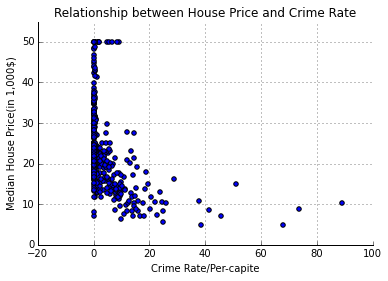

In [8]:
# Create the scatter plot to show the relationship between the CRIM and median house price

#Get the data of crime rate of per-capite
crim = bdata.data[:,0] 

#Plot the crim and median house price
#Remove the top and right bars
ax = plt.subplot(111)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.tick_params(top="off", right="off")

#Make the graph
plt.scatter(crim, bdata.target)
plt.xlabel('Crime Rate/Per-capite')
plt.ylabel('Median House Price(in 1,000$)')
plt.title('Relationship between House Price and Crime Rate')
plt.ylim([0,55])
plt.grid()
plt.show()

In [3]:
#Normalize features, call the normalize function
def normalize(raw_data):
    #initialize array
    raw = np.array(raw_data)
    normalized_data = np.zeros_like(raw)
    
    #calculate mean, std, z
    mean = raw.mean(axis=0)
    std = raw.std(axis=0)
    normalized_data = (raw - mean)*1.0 / std
    return normalized_data

#Normalize all the features and put them to new dataset
n_bdata = normalize(bdata.data)

#Split the whole dataset to training dataset and testing dataset
bdata_train, bdata_test, btarget_train, btarget_test = train_test_split(n_bdata, bdata.target, test_size=0.34, random_state=42)

#Get the average number of rooms per house
rm_train = bdata_train[:,5:6]
rm_test = bdata_test[:,5:6]

#Generate the linear regression equation
from sklearn import linear_model
slr = linear_model.LinearRegression()

#Use the training dataset to fit the model
slr.fit(rm_train,btarget_train)

#Get the slope coefficient and the interpret coefficient
s_coef = slr.coef_
i_coef = slr.intercept_


#Report the RMSE
#Get the RMSE function
def compute_rmse(predictions, yvalues):
    if len(predictions) != len(yvalues):
        return False
    length = len(yvalues)
    sum = 0
    for i in range(length):
        diff = pow((predictions[i] - yvalues[i]),2)
        sum = sum + diff
    rmse = np.sqrt(float(sum)/length)
    return rmse


#Calcualte the RMSE for training and testing dataset
RMSE_test = compute_rmse(i_coef+s_coef*rm_test, btarget_test)
RMSE_train = compute_rmse(i_coef + s_coef*rm_train, btarget_train)

#Print out the result
print "The RMSE for training dataset is: %f"%(RMSE_train)
print "The RMSE for testing dataset is: %f"%(RMSE_test)

The RMSE for training dataset is: 6.806289
The RMSE for testing dataset is: 6.194636


###4.2 So many scatterplots!

Choose 8 out of the of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

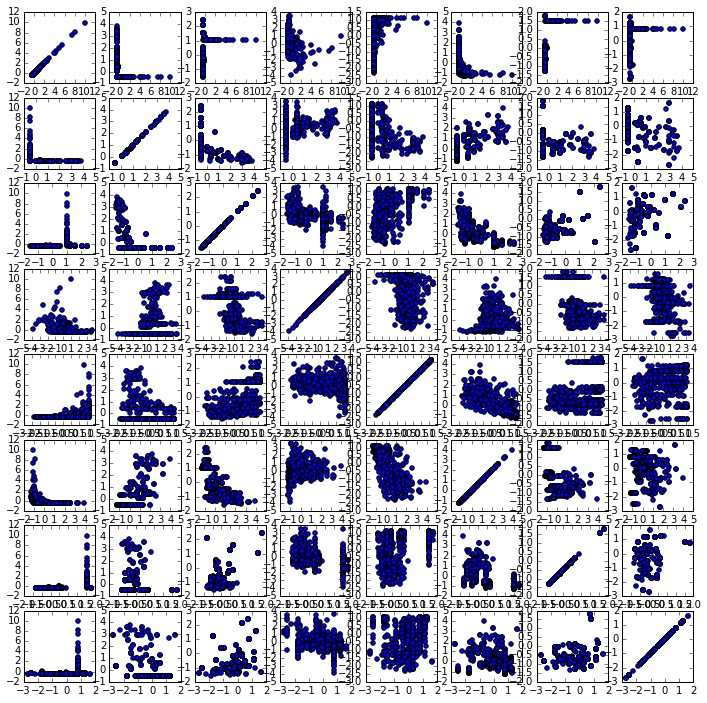

In [20]:
#Create a new dataset that includes 8 features('CRIM','ZN','INDUS','RM','AGE','DIS','TAX','PTRATIO')
new_bdata = n_bdata[:,[0,1,2,5,6,7,9,10]]

plt.figure(figsize=(12,12))
for i in xrange(8):
    for j in xrange(8):
        plt.subplot(8, 8, i * 8 + j + 1)
        plt.scatter(new_bdata[:,i], new_bdata[:,j])
        # insert your code here

###4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

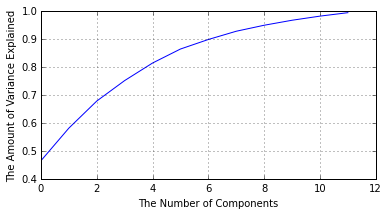

In [26]:
# Enter your code here
from sklearn.decomposition import PCA

#Get the model and use the training dataset to fit the model
pca = PCA(n_components=12)
pca.fit(bdata_train)

#Calculate the amount of variance explained by compponents
w_amount = []
plt.figure(figsize=(6,3))
for i in range(1, 13):
    pca = PCA(n_components = i)
    pca.fit(bdata_train)
    amount = np.sum(pca.explained_variance_ratio_)
    #print amount
    w_amount.append(amount)
    
#Plot the result
plt.plot(w_amount)
plt.xlabel('The Number of Components')
plt.ylabel('The Amount of Variance Explained')
plt.grid()

###4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

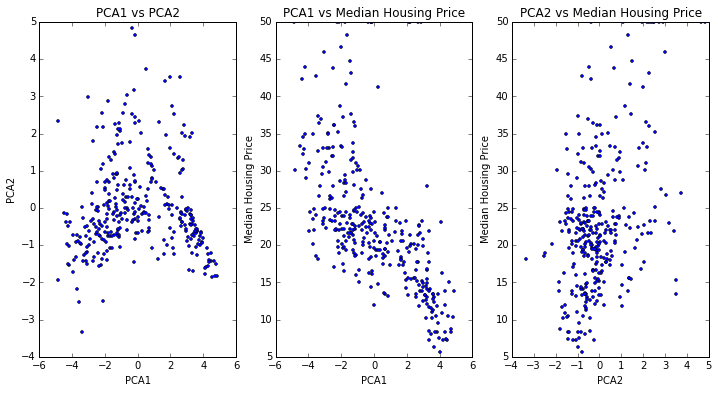

In [27]:
# Enter your code here
trans_train= pca.fit_transform(bdata_train)
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.plot(trans_train[:,0], trans_train[:,1], 'o',markersize = 3)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("PCA1 vs PCA2")

plt.subplot(1,3,2)
plt.plot(trans_train[:,0], btarget_train, 'o',markersize = 3)
plt.xlabel("PCA1")
plt.ylabel("Median Housing Price")
plt.title("PCA1 vs Median Housing Price")

plt.subplot(1,3,3)
plt.plot(trans_train[:,1], btarget_train, 'o',markersize = 3)
plt.xlabel("PCA2")
plt.ylabel("Median Housing Price")
plt.title("PCA2 vs Median Housing Price")

###4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

In [22]:
from sklearn.linear_model import LinearRegression

trans_train= pca.fit_transform(bdata_train)
trans_test = pca.fit_transform(bdata_test)

#Get the model
lr = LinearRegression()

#Use the training dataset to fit the model
lr.fit(trans_train[:,0:1], btarget_train)

#Make the prediction
pre_train = lr.predict(trans_train[:,0:1])
pre_test = lr.predict(trans_test[:,0:1])

print "RMSE of the training dataset is: %f"%compute_rmse(pre_train,btarget_train)
print "RMSE of the testing dataset is: %f"%compute_rmse(pre_test,btarget_test)

RMSE of the training dataset is: 7.550446
RMSE of the testing dataset is: 6.817090


*Enter your observations here*

The RMSEs (for training and testing datasets) both become larger than before.